In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statistics import median
import numpy as np
import functools as ft
from scipy.stats import wilcoxon

In [4]:
import itertools as it

from bisect import bisect_left
from typing import List

import numpy as np
import pandas as pd
import scipy.stats as ss

from pandas import Categorical


def VD_A(treatment: List[float], control: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000

    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/

    :param treatment: a numeric list
    :param control: another numeric list

    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    # A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude


def VD_A_DF(data, val_col: str = None, group_col: str = None, sort=True):
    """

    :param data: pandas DataFrame object
        An array, any object exposing the array interface or a pandas DataFrame.
        Array must be two-dimensional. Second dimension may vary,
        i.e. groups may have different lengths.
    :param val_col: str, optional
        Must be specified if `a` is a pandas DataFrame object.
        Name of the column that contains values.
    :param group_col: str, optional
        Must be specified if `a` is a pandas DataFrame object.
        Name of the column that contains group names.
    :param sort : bool, optional
        Specifies whether to sort DataFrame by group_col or not. Recommended
        unless you sort your data manually.

    :return: stats : pandas DataFrame of effect sizes

    Stats summary ::
    'A' : Name of first measurement
    'B' : Name of second measurement
    'estimate' : effect sizes
    'magnitude' : magnitude

    """

    x = data.copy()
    if sort:
        x[group_col] = Categorical(x[group_col], categories=x[group_col].unique(), ordered=True)
        x.sort_values(by=[group_col, val_col], ascending=True, inplace=True)

    groups = x[group_col].unique()

    # Pairwise combinations
    g1, g2 = np.array(list(it.combinations(np.arange(groups.size), 2))).T

    # Compute effect size for each combination
    ef = np.array([VD_A(list(x[val_col][x[group_col] == groups[i]].values),
                        list(x[val_col][x[group_col] == groups[j]].values)) for i, j in zip(g1, g2)])

    return pd.DataFrame({
        'A': np.unique(data[group_col])[g1],
        'B': np.unique(data[group_col])[g2],
        'estimate': ef[:, 0],
        'magnitude': ef[:, 1]
    })

In [5]:
def get_significant_classes_stats(output_csv, search_budget, compared_function):
        res = pd.read_csv(output_csv)
        configuration_ids = ['weak_' + str(search_budget), 'branch_' + str(search_budget), 'default_' + str(search_budget)]

        # Sort by configuration
        res = res.loc[:,['TARGET_CLASS', 'configuration_id', 'project.id', 'BranchCoverage']]
        result = res[res.apply(lambda row : row["configuration_id"] in configuration_ids, axis=1)]

        # "weak" groups
        weak_result = result.loc[result['configuration_id'] == 'weak_' + str(search_budget)]
        weak_groups = weak_result.groupby(['TARGET_CLASS', 'configuration_id', 'project.id'])['BranchCoverage']

        # "compared" groups
        compared_func_result = result.loc[result['configuration_id'] == str(compared_function) + '_' + str(search_budget)]
        compared_func_groups = compared_func_result.groupby(['TARGET_CLASS', 'configuration_id', 'project.id'])['BranchCoverage']

        # Create a dictionary with the 10 runs per class and the resulting branch coverage for the weak + branch fitness function
        weak_classes = dict()
        for name, group in weak_groups:
            weak_classes[name] = group.astype(float).to_numpy()

        # Create a dictionary with the 10 runs per class and the resulting branch coverage for the compared fitness function
        compared_func_classes = dict()
        for name, group in compared_func_groups:
            compared_func_classes[name] = group.astype(float).to_numpy()

        # If there are less than 10 runs for a class, pad the branch coverage with 0 
        def pad(val1, val2):
            if val1.shape[0] == val2.shape[0]:
                return val1, val2
            if val1.shape[0] < val2.shape[0]:
                return np.pad(val1, [(0, val2.shape[0]-val1.shape[0])]), val2
            else:
                return val1, np.pad(val2, [(0, val1.shape[0]-val2.shape[0])])

        # Calculate statistical significance per class
        # Apply the Wilcoxon test for (weak_classes, compared_classes) per batch of 10 runs
        # Apply A. Vargha and H. D. Delaney. per batch
        # Filter out non-significant classes and classes with less than 'large' effect size
        class_stats = dict()
        for ((key1, val1), (key2, val2)) in zip(weak_classes.items(), compared_func_classes.items()):
            val1, val2 = pad(val1, val2)
            stats_p = (-2,-2) if (np.sum(np.subtract(val1, val2)) == 0) else wilcoxon(val1, val2)
            vd = VD_A(val1.tolist(), val2.tolist())
            class_stats[key1[0]] = (stats_p, vd)
            # print(str(key1) + str(val1) + ", "+ str(key2) + str(val2) + " HAS P VALUE OF: " + str(p))

        significant_class_stats = dict()
        for (key, ((stats, p), vd)) in class_stats.items():
            if (p > -2 and p < 0.05 and vd[1] == 'large'):
                significant_class_stats[key] = ((stats, p), vd) 
        
        # Return statistically significant class stats & all classes stats (stats = p-values)
        return significant_class_stats, class_stats

In [7]:
# Diverging Texts plot

def plot_diverging_text(search_budget, compared_class, classes_with_stats):

    df1 = pd.DataFrame.from_dict(classes_with_stats, orient='index')
    df1.rename(columns = {0: 'wilcoxon', 1:'vd'}, inplace = True)

    vd_df = df1.drop('wilcoxon', axis=1)
    df2 = (vd_df.apply(lambda x: x[0], axis=1, result_type='expand')).drop([1], axis=1)
    df2.rename(columns = {0: 'vd_estimate'}, inplace = True)
    # df = df2.iloc[: 100]
    df = df2
    df.sort_values('vd_estimate', inplace=True)
    # df = df.iloc[30:65]

    # Draw plot
    plt.figure(figsize=(20,20), dpi= 80)
    plt.hlines(y=df.index, xmin=0.5, xmax=df.vd_estimate)
    for x, y, tex in zip(df.vd_estimate, df.index, df.vd_estimate):
        t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x >= 0.5 else 'left', 
                     verticalalignment='bottom', fontdict={'color':'red' if x < 0.5 else 'green', 'size':18})

    # Decorations    
    plt.yticks(df.index, fontsize=12)
    plt.title('Effect size per class - bcwm vs ' + compared_class + ' - search budget ' + str(search_budget), fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(-0.25, 1.25)
    plt.show()


C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\danie\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


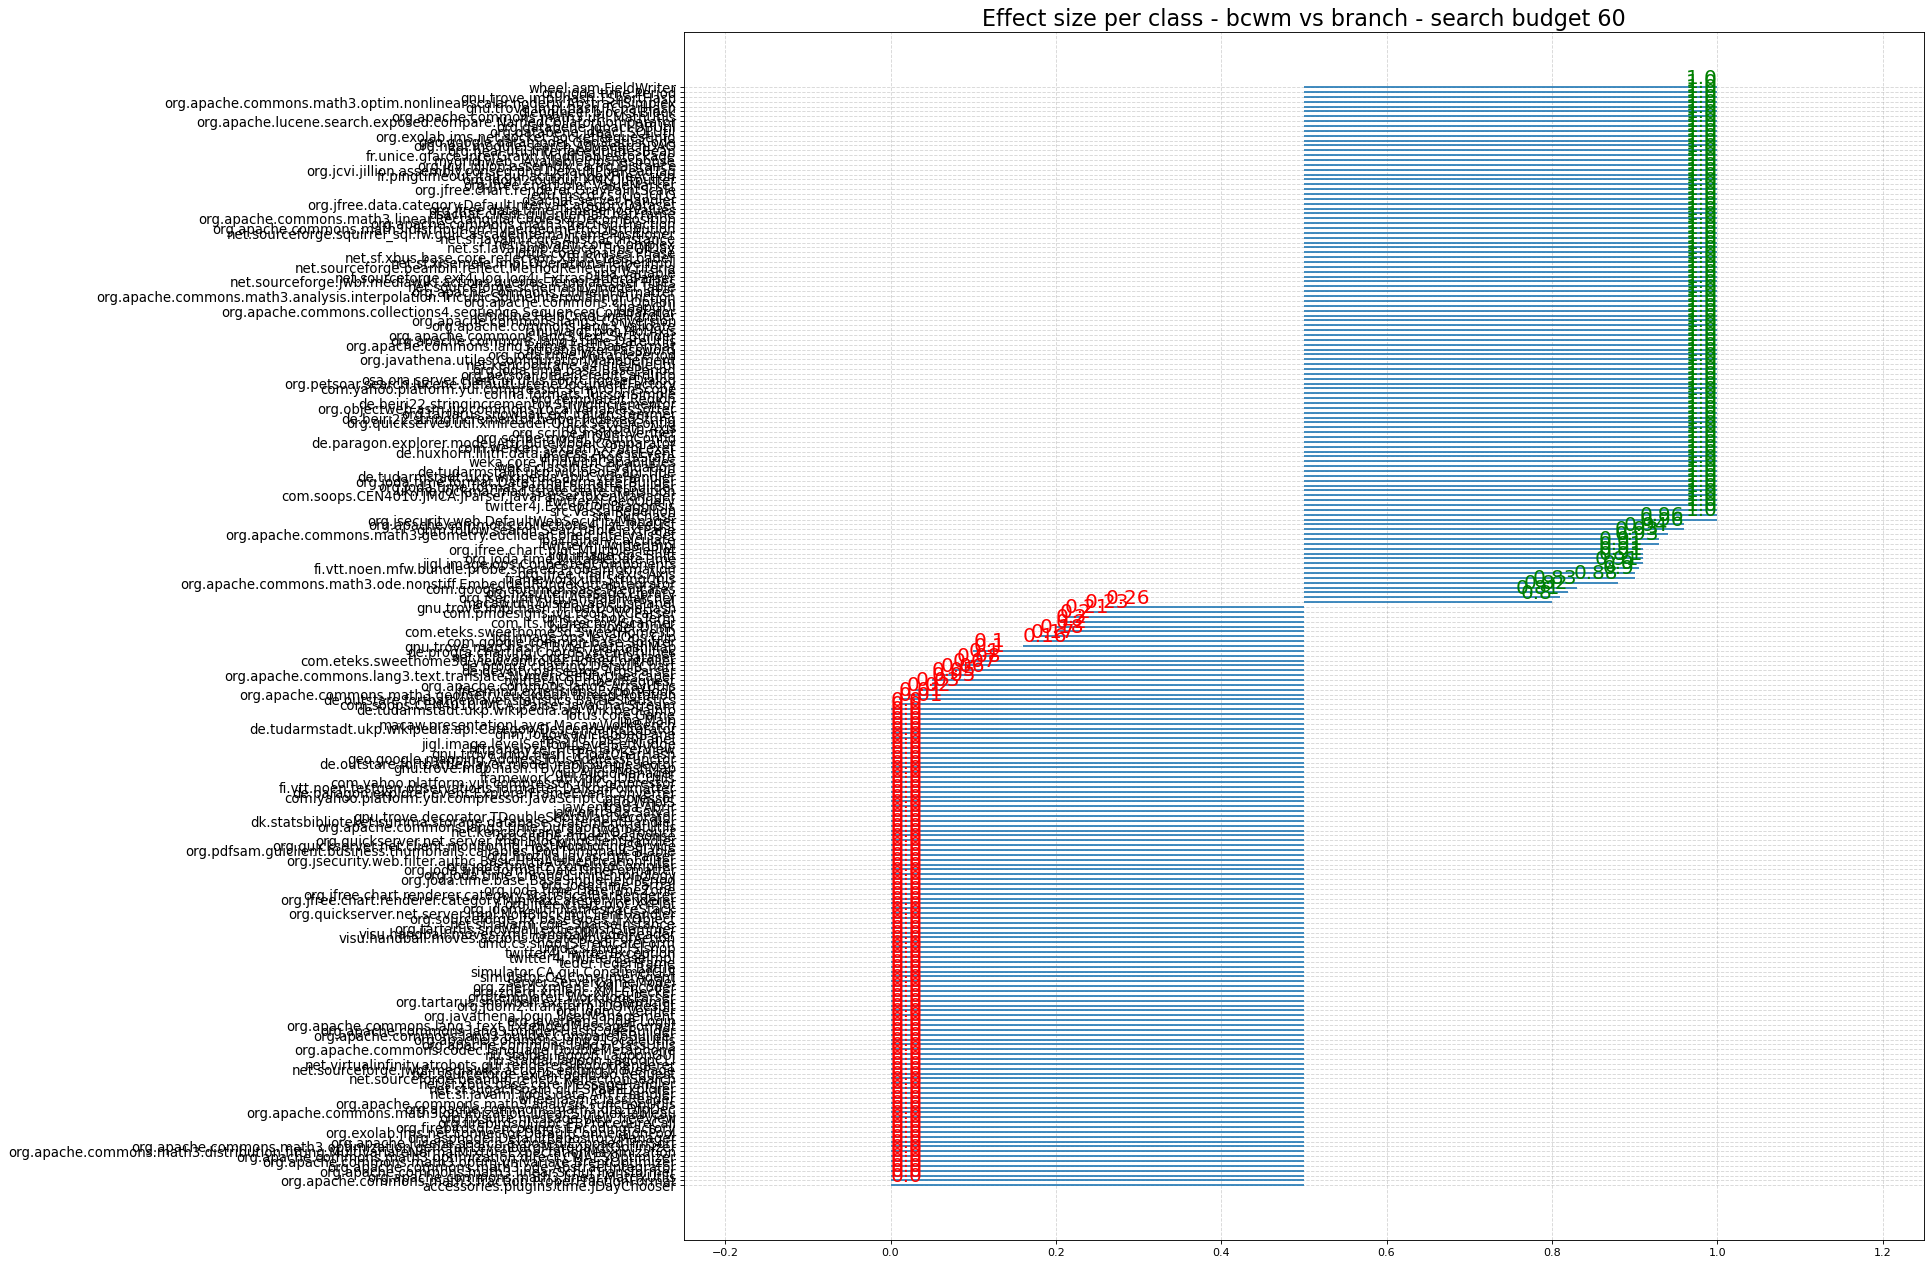

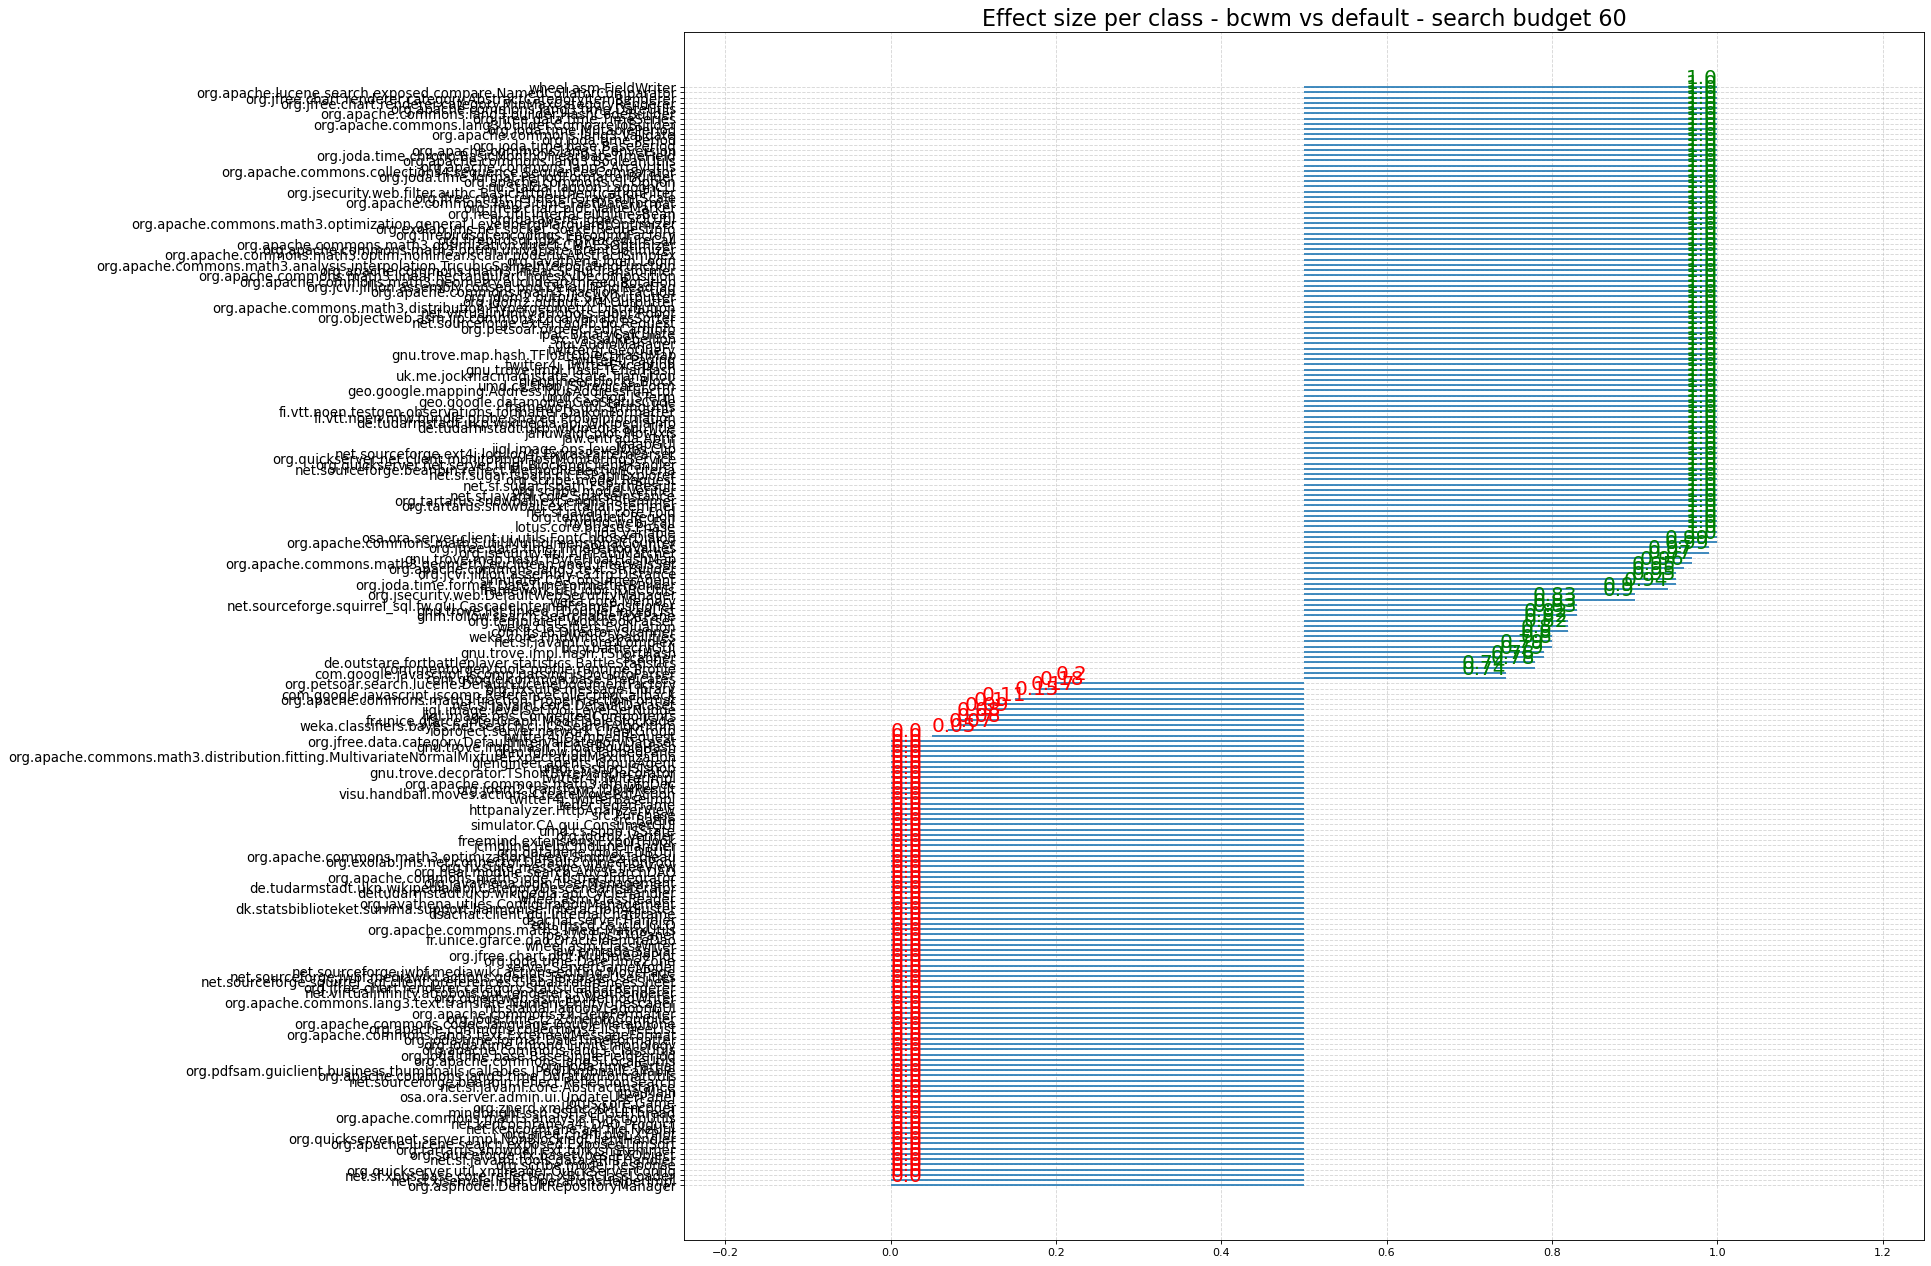

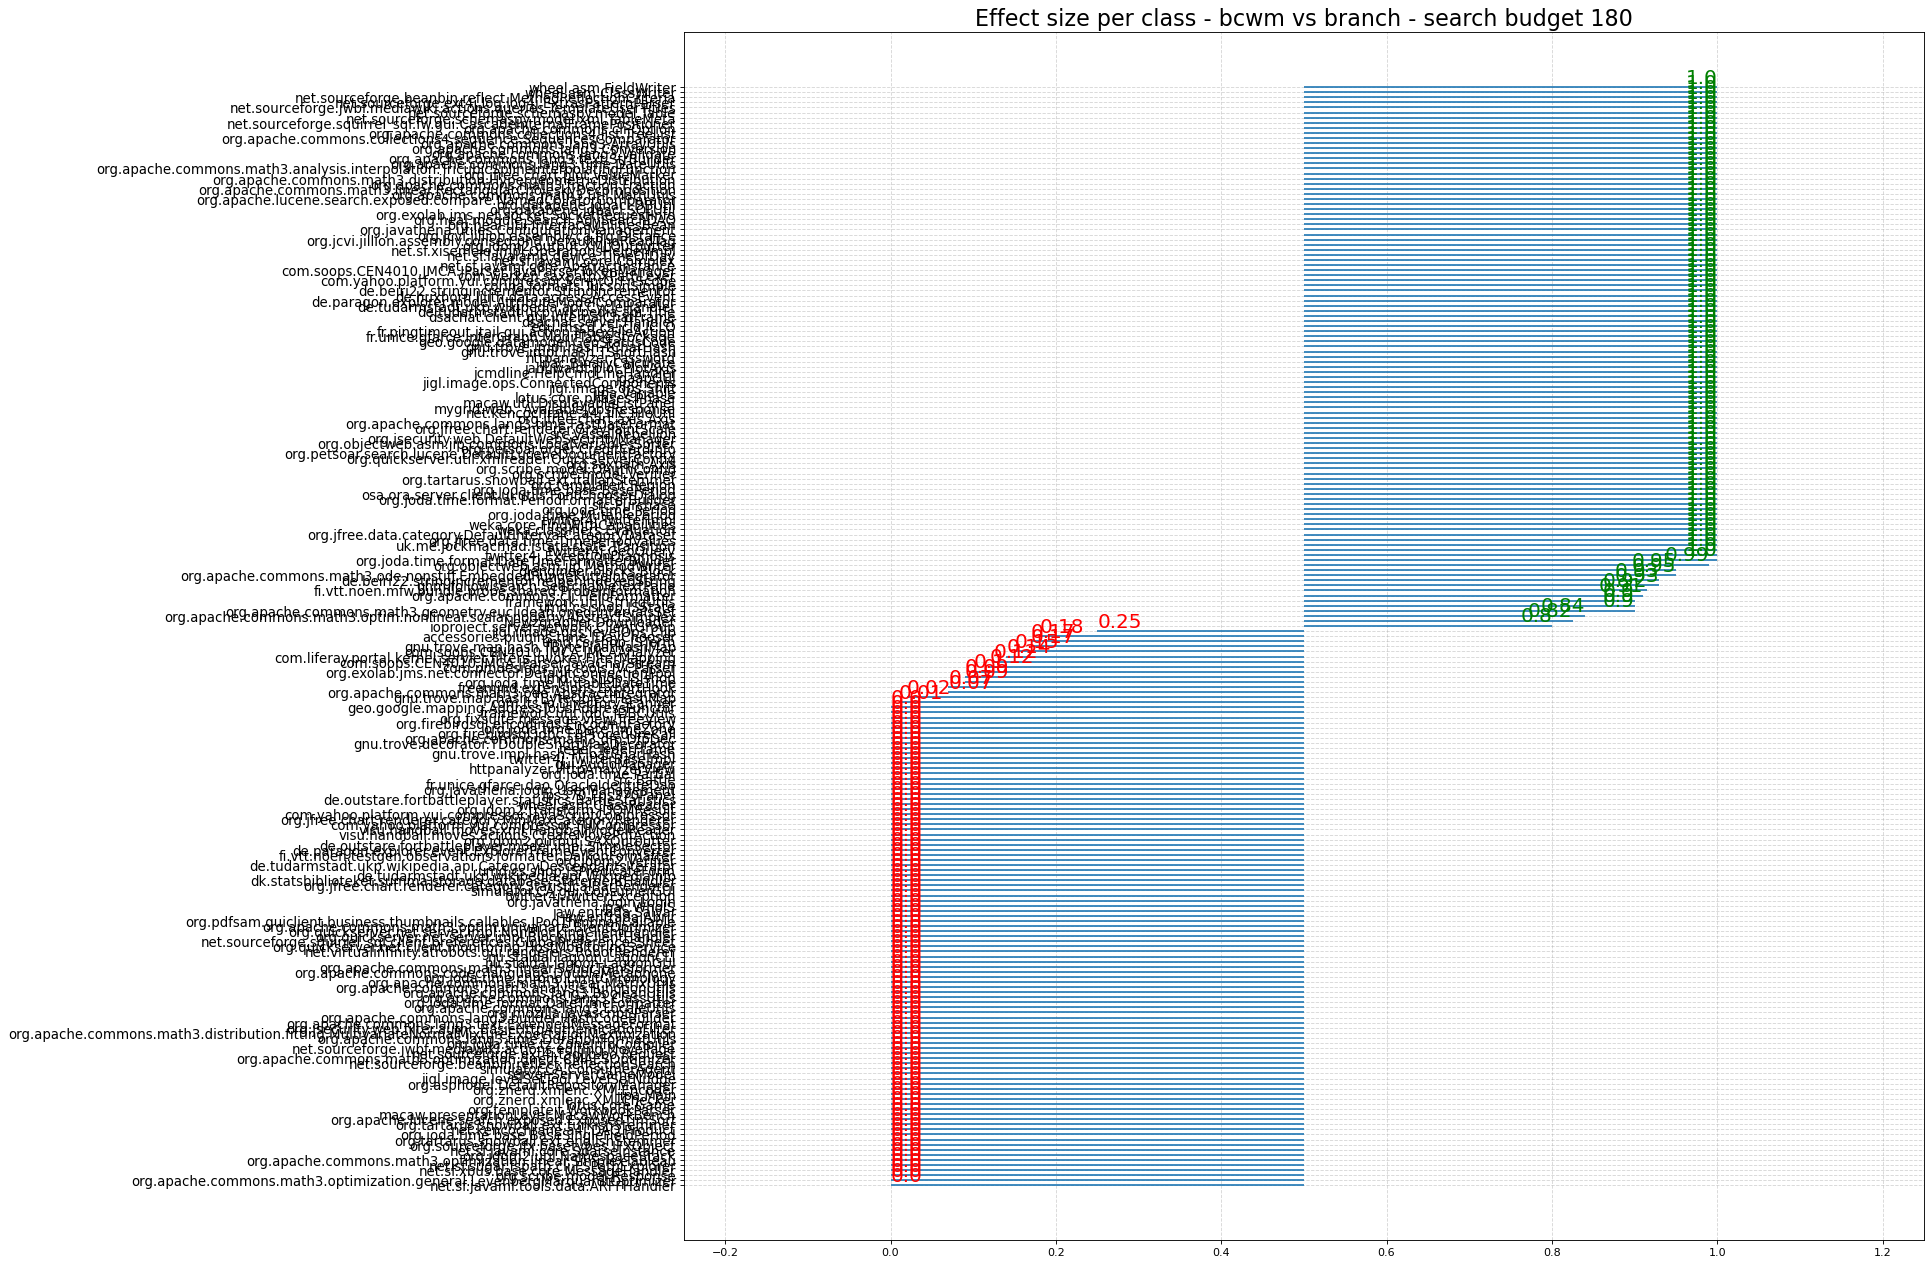

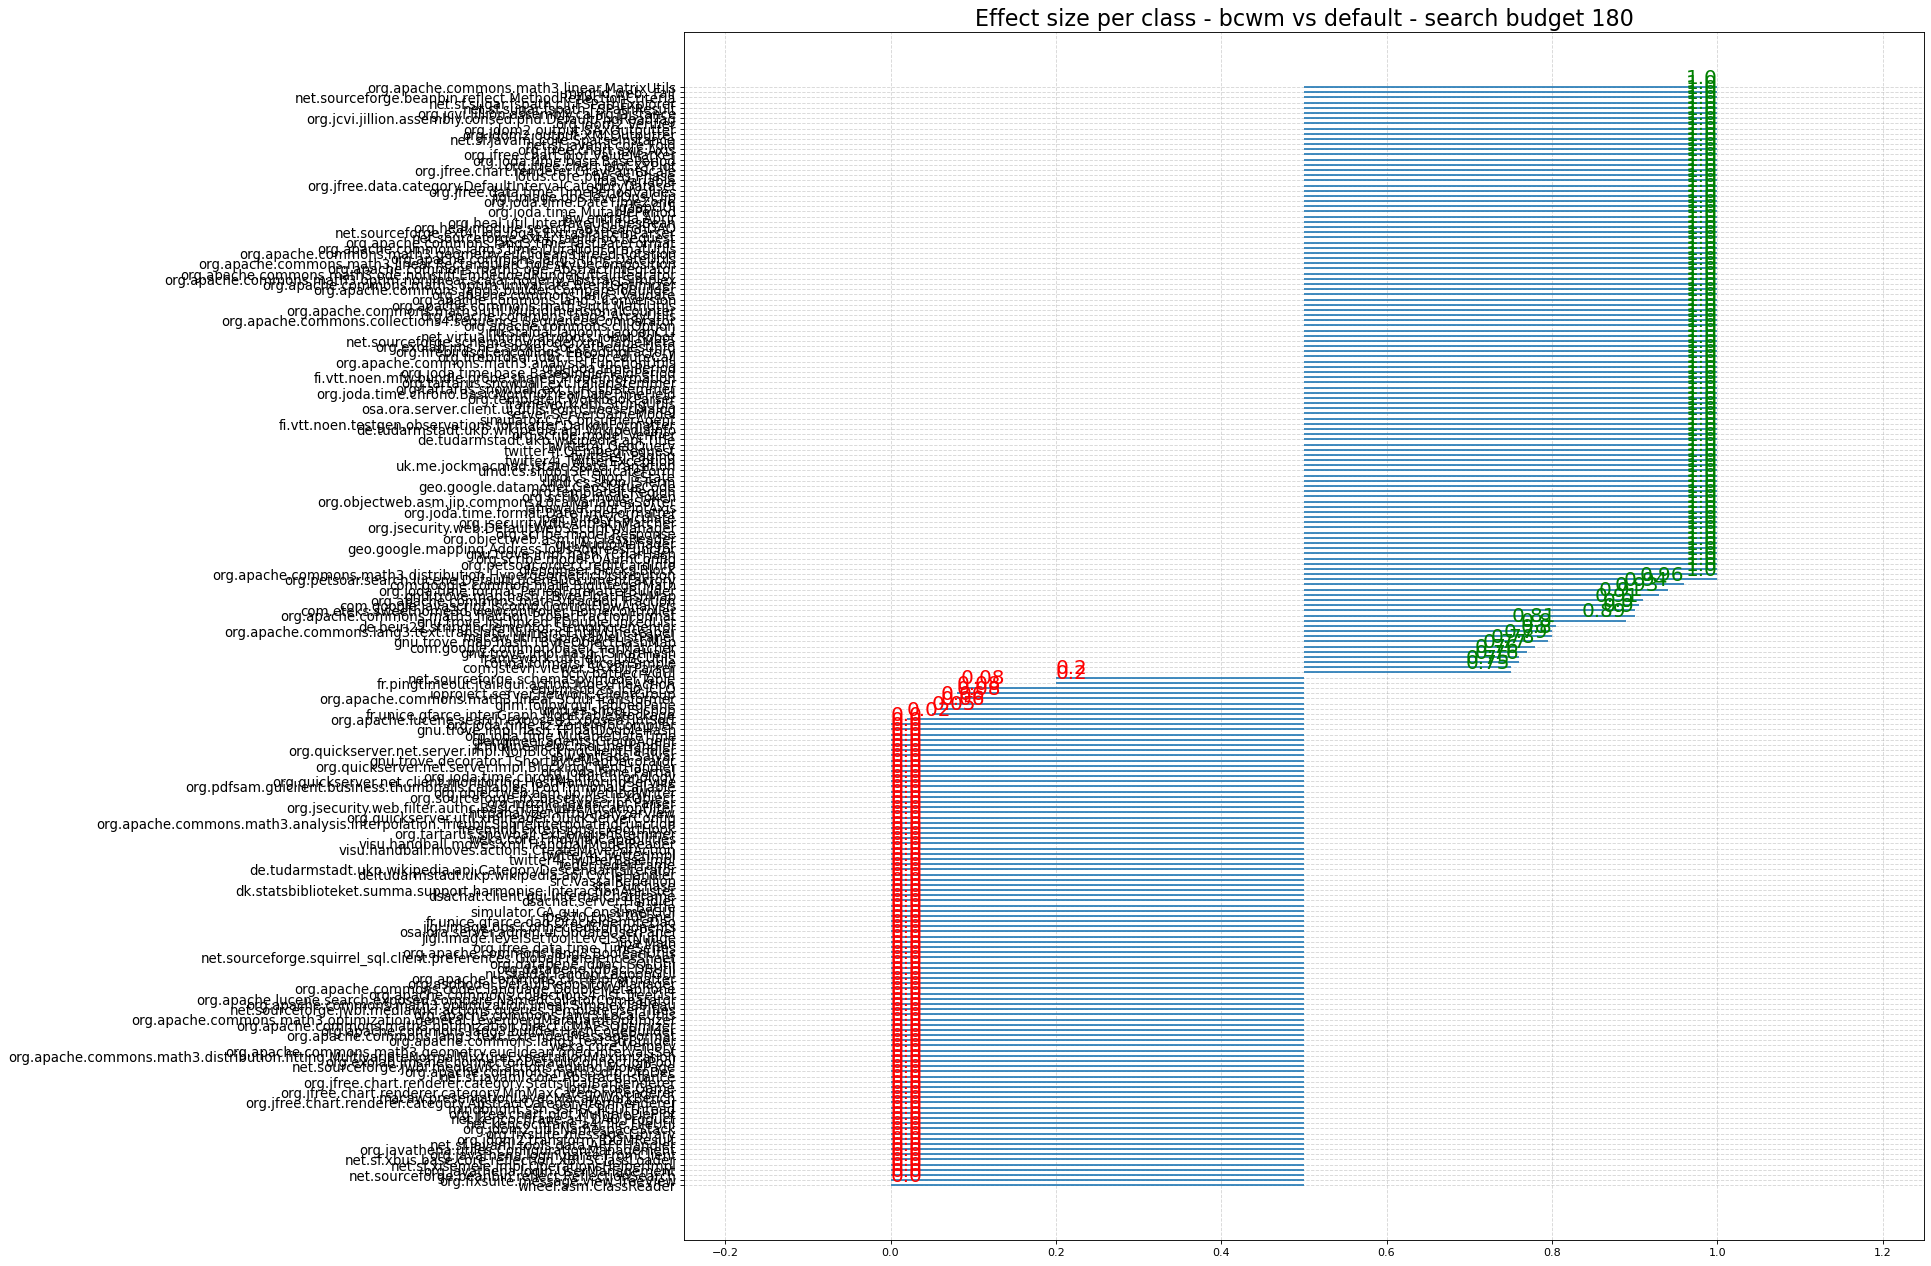

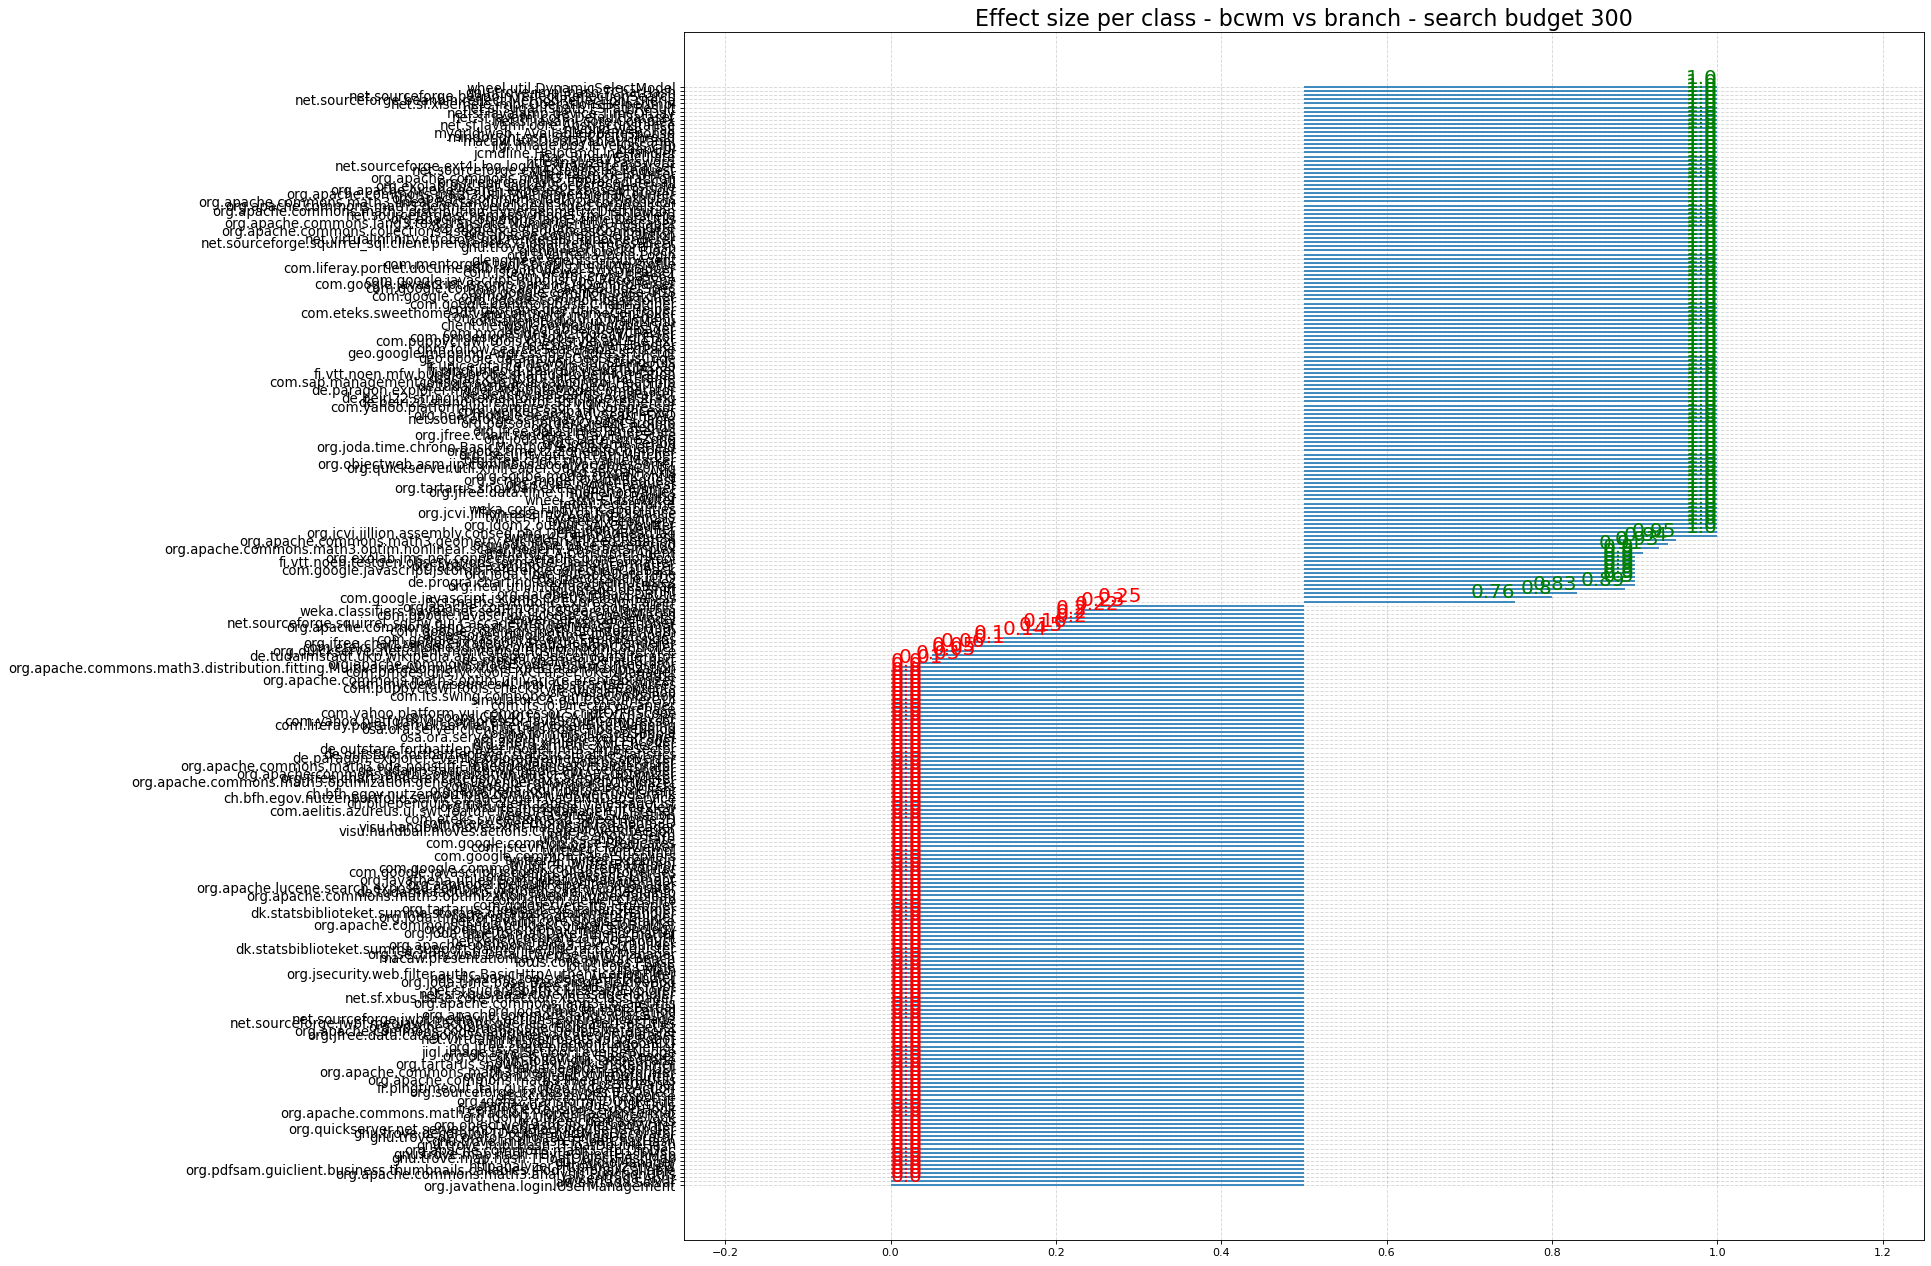

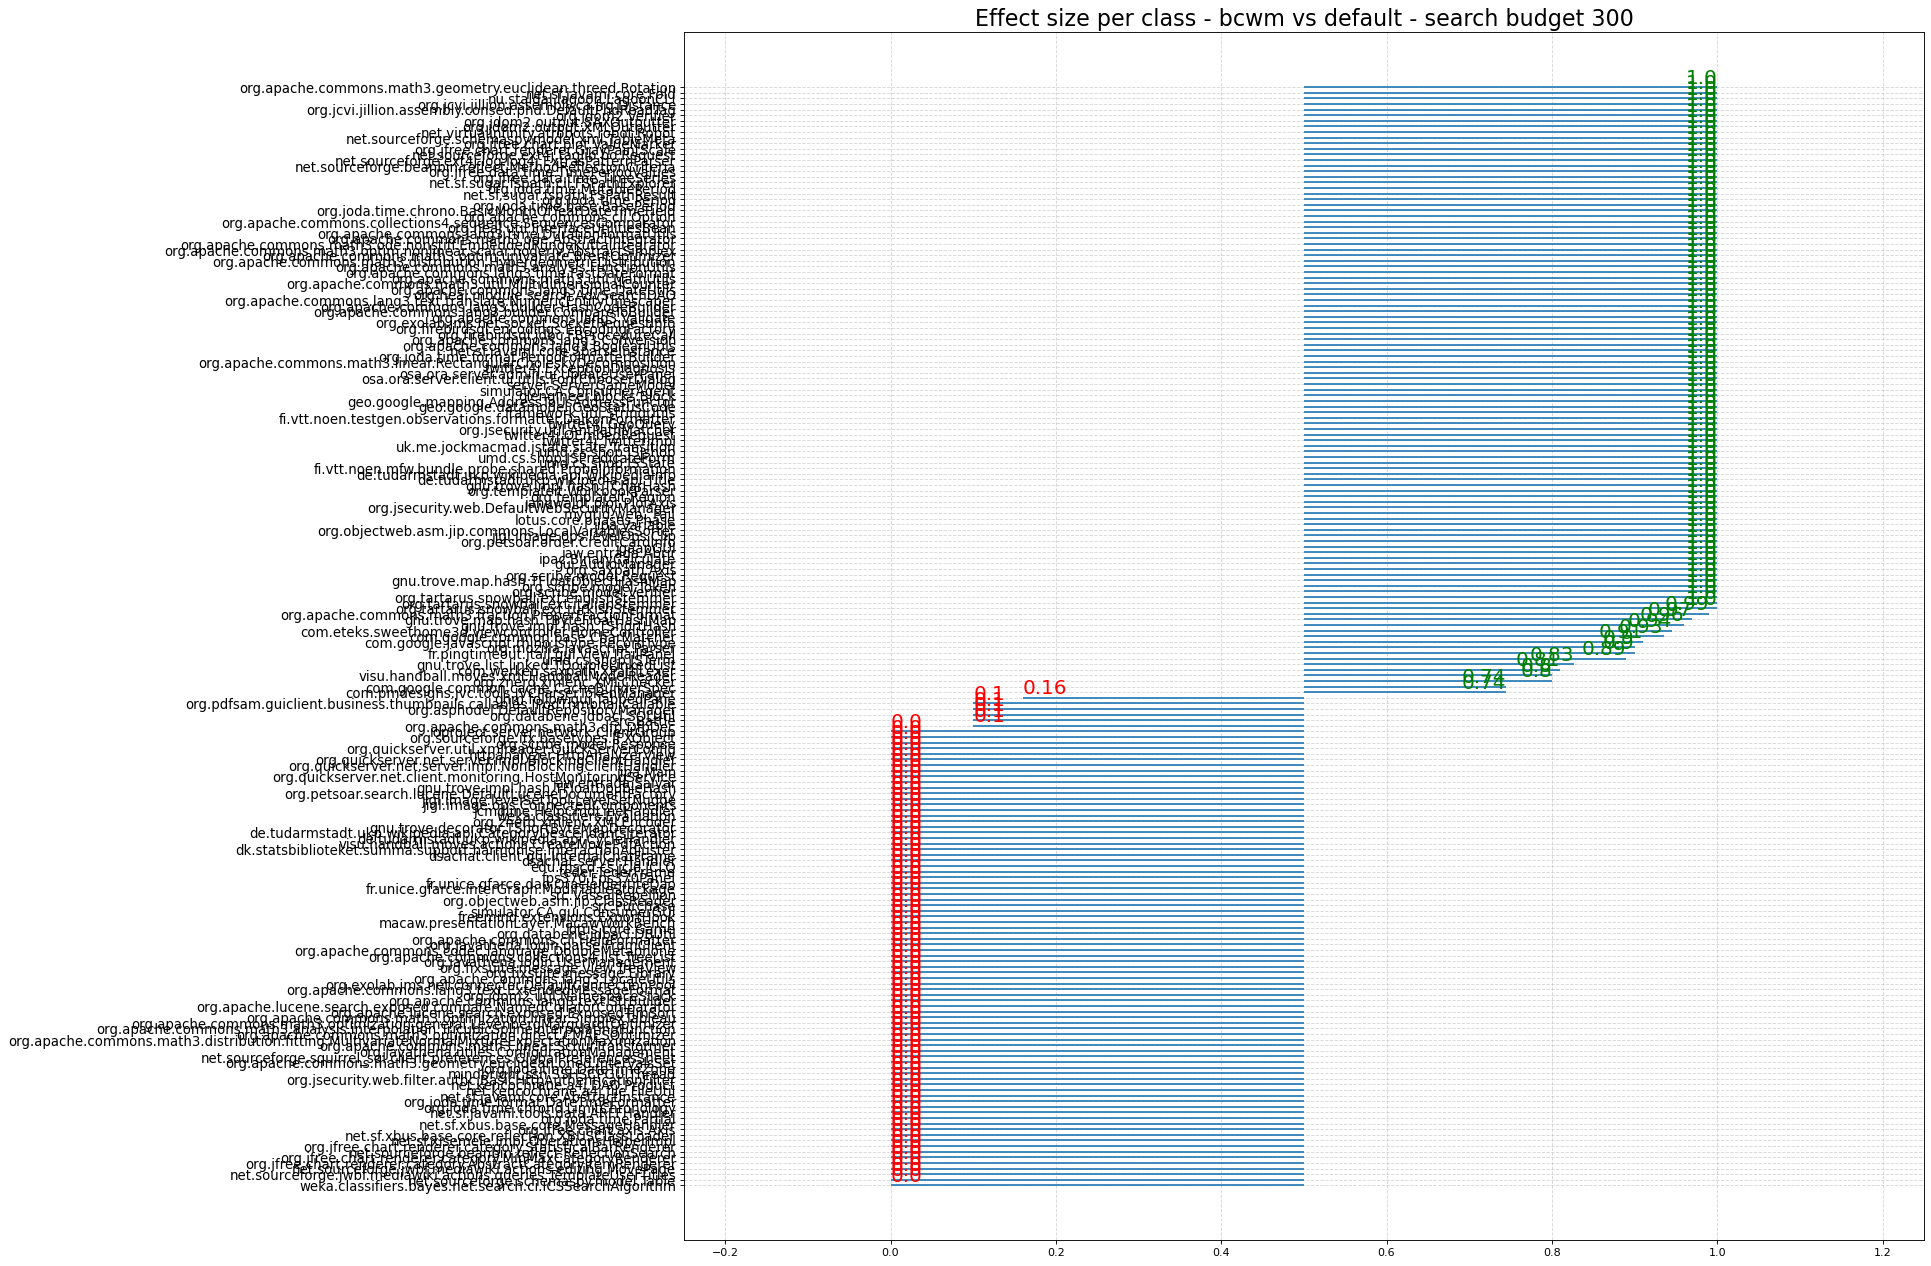

In [8]:
def plot_forall_budgets(search_budgets=[60, 180, 300]):
    
    for search_budget in search_budgets:
        significant_classes_stats = {}
        key_budget = 'stats' + str(search_budget)

        # Contains the coverage results per class from EvoSuite (e.g. coverage_res_filename = "res_data/results-60.csv")
        coverage_res_filename = 'res_data/results-' + str(search_budget) + '.csv'
        
        
        # significant_classes_stats['stats60_fitness'][0][class][0] -> Wilcoxon results (tuple) for significant classes
        # significant_classes_stats['stats60_fitness'][0][class][1] -> Vargha-Delaney results (tuple) for significant classes
        # Use ['stats60_fitness'][1] for all classes stats and not only the significant ones
        # Contains statistically significant classes at [0] and all classes at [1]
        # res_dict['stats60_branch'][0].items() contains pairs of type (class_name, p-value)
        significant_classes_stats[str(key_budget + '_branch')] = get_significant_classes_stats(coverage_res_filename, search_budget, 'branch')
        significant_classes_stats[str(key_budget + '_default')] = get_significant_classes_stats(coverage_res_filename, search_budget, 'default')


        plot_diverging_text(search_budget, 'branch', significant_classes_stats[str(key_budget + '_branch')][0])
        plot_diverging_text(search_budget, 'default', significant_classes_stats[str(key_budget + '_default')][0])
        
plot_forall_budgets()    